In [191]:
from pyspark.ml.feature import PCA, VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import pyspark as p
import seaborn as sns

%matplotlib inline

In [91]:
# sc.stop()

In [3]:
sc = p.SparkContext('local[*]')
sql = p.SQLContext(sc)

In [100]:
train = sql.read.format('com.databricks.spark.csv').options(header="true",inferSchema="true").load('dog-train.csv')
test = sql.read.format('com.databricks.spark.csv').options(header="true",inferSchema="true").load('dog-test.csv')

In [101]:
def calculate_days(string):
    try:
        count = int(string.split(' ')[0])
        measure = string.split(' ')[-1]
        if measure[-1] == 's':
            measure = measure[:-1]
        if measure == 'month':
            return count*30
        elif measure == 'week':
            return count*7
        elif measure == 'year':
            return count*365
        else:
            return count
    except Exception,e:
        return None

In [102]:
def get_gender(string):
    try:
        if string.lower() != "unknown":
            return string.split(' ')[-1].lower()
        else:
            return 'unknown'
    except Exception,e:
        return str(e)

In [103]:
def get_fix(string):
    try:
        if string.lower() != "unknown":
            status = string.split(' ')[0].lower()
            if status == 'intact':
                return status
            elif status in ['spayed','neutered']:
                return "fixed"
            else:
                return "unknown"
        elif string.lower() == 'unknown':
            return "unknown"
        else:
            return None
    except Exception,e:
        return e

In [104]:
calculate_days_udf = p.sql.functions.udf(calculate_days,p.sql.types.IntegerType())
get_gender_udf = p.sql.functions.udf(get_gender)
get_fix_udf = p.sql.functions.udf(get_fix)

In [171]:
train_features = (train.withColumn('fixed_flag',get_fix_udf(train['SexuponOutcome']))
                  .withColumn('gender',get_gender_udf(train['SexuponOutcome']))
                  .withColumn('days_before_outcome',calculate_days_udf(train['AgeuponOutcome']))
                  .drop('SexuponOutcome')
                  .drop('AgeuponOutcome')
                 )

In [106]:
train.printSchema()

root
 |-- AnimalID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- DateTime: timestamp (nullable = true)
 |-- OutcomeType: string (nullable = true)
 |-- OutcomeSubtype: string (nullable = true)
 |-- AnimalType: string (nullable = true)
 |-- SexuponOutcome: string (nullable = true)
 |-- AgeuponOutcome: string (nullable = true)
 |-- Breed: string (nullable = true)
 |-- Color: string (nullable = true)



In [107]:
test.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- DateTime: timestamp (nullable = true)
 |-- AnimalType: string (nullable = true)
 |-- SexuponOutcome: string (nullable = true)
 |-- AgeuponOutcome: string (nullable = true)
 |-- Breed: string (nullable = true)
 |-- Color: string (nullable = true)



In [108]:
test_features = (test.withColumn('fixed_flag',get_fix_udf(test['SexuponOutcome']))
                  .withColumn('gender',get_gender_udf(test['SexuponOutcome']))
                  .withColumn('days_before_outcome',calculate_days_udf(test['AgeuponOutcome']))
                  .drop('SexuponOutcome')
                  .drop('AgeuponOutcome')
                 )

In [174]:
def create_dummies(df,col):
    filtered_data = df.where(df[col].isNotNull())
    indexer = StringIndexer(inputCol=col,outputCol=col + "_index")
    model = indexer.fit(filtered_data)
    indexed = model.transform(filtered_data)
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vector")
    encoded = encoder.transform(indexed)
    return encoded

In [175]:
interested_list = ['fixed_flag','gender','Breed','Color','AnimalType','OutcomeType']

In [176]:
train_final = train_features
for col in interested_list:
    train_final = create_dummies(train_final,col)

In [177]:
test_final = test_features
for col in interested_list[:-1]:
    test_final = create_dummies(test_final,col)

In [178]:
(train_final, test_final) = train_final.randomSplit([0.7, 0.3])

In [179]:
feature_list = [x + '_vector' for x in interested_list[:-1]]
label = 'OutcomeType_index'
features_assembler = VectorAssembler(inputCols=feature_list,outputCol="features")

In [193]:
k = list()
for i in range(1,6,1):
    rf = RandomForestClassifier(featuresCol="features",labelCol=label,maxDepth=26,numTrees=i)
    pipeline = Pipeline(stages=[features_assembler,rf])
    predictions = pipeline.fit(train_final).transform(test_final)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol="prediction", metricName="precision")
    mse = evaluator.evaluate(predictions)
    k.append([i,mse])

In [194]:
z = []
for x,y in k:
    z.append([x,y])

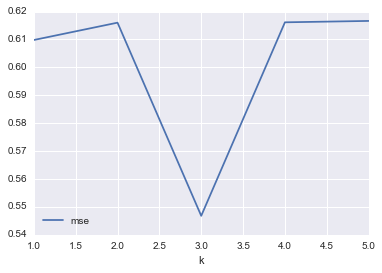

In [195]:
pd.DataFrame(k, columns=['k', 'mse']).plot(x='k', y='mse', kind='line')